In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [101]:
import keras
import keras.utils
from keras import utils as np_utils

In [102]:
main_dir = r"C:\Users\Aniket Verma\Desktop\Covid Mask Detection\New Masks Dataset"
train_dir = os.path.join(main_dir,'Train')
test_dir = os.path.join(main_dir,'Test')
valid_dir = os.path.join(main_dir,'Validation')
train_mask_dir = os.path.join(train_dir,'Mask')
train_nomask_dir = os.path.join(train_dir,'Non Mask')


In [103]:
train_mask_names = os.listdir(train_mask_dir)
print(train_mask_names[:10])                      #check if your directory is linked properly
print(len(train_mask_names))
train_nomask_names = os.listdir(train_nomask_dir) 
print(len(train_nomask_names))
print(train_nomask_names[:10])

['0003.jpg', '0006.jpg', '0018.jpg', '0019.jpg', '0022.jpg', '0027.jpg', '0029.jpg', '0037.jpg', '0040.jpg', '0042.jpg']
300
300
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg']


In [104]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.2,
                                   rotation_range = 40,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )
valid_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [105]:
train_img,train_labels = train_generator.next()
test_img,test_labels = test_generator.next()

In [106]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(150,150,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])

  
  return model

In [107]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [108]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=7,directory='output3',project_name="tuning3")

INFO:tensorflow:Reloading Oracle from existing project output3\tuning3\oracle.json


In [109]:

tuner_search.search(train_img,train_labels,epochs=10,validation_data=valid_generator)


Trial 7 Complete [00h 04m 48s]
val_accuracy: 0.6470588445663452

Best val_accuracy So Far: 0.7352941036224365
Total elapsed time: 00h 38m 46s
INFO:tensorflow:Oracle triggered exit


In [110]:
model=tuner_search.get_best_models(num_models=1)[0]

In [111]:
history=model.fit(train_generator, validation_data = valid_generator, epochs=20, initial_epoch=10)

Epoch 11/20
19/19 [==============================] - 375s 19s/step - loss: 0.9275 - accuracy: 0.7300 - val_loss: 0.5236 - val_accuracy: 0.7418
Epoch 12/20
19/19 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7767  - ETA: 46s - loss: 0.5317 - accuracy:  - 473s 26s/step - loss: 0.5154 - accuracy: 0.7767 - val_loss: 0.3326 - val_accuracy: 0.8791
Epoch 13/20
19/19 [==============================] - 455s 16s/step - loss: 0.2913 - accuracy: 0.8917 - val_loss: 0.4946 - val_accuracy: 0.8137
Epoch 14/20
19/19 [==============================] - 176s 9s/step - loss: 0.4204 - accuracy: 0.8167 - val_loss: 0.4981 - val_accuracy: 0.7908
Epoch 15/20
19/19 [==============================] - 169s 9s/step - loss: 0.3212 - accuracy: 0.8800 - val_loss: 0.6802 - val_accuracy: 0.7810
Epoch 16/20
19/19 [==============================] - 166s 9s/step - loss: 0.3372 - accuracy: 0.8783 - val_loss: 0.6172 - val_accuracy: 0.7418
Epoch 17/20
19/19 [==============================] - 171s 9s/

Text(0.5, 0, 'epoch')

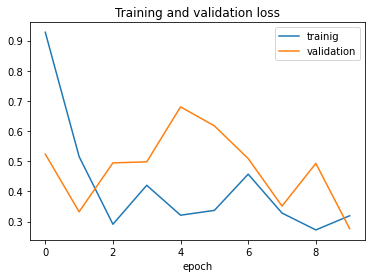

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['trainig','validation'])
plt.title('Training and validation loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

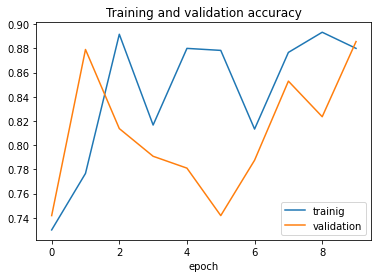

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['trainig','validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [114]:
test_loss , test_acc = model.evaluate(test_generator)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 16s 4s/step - loss: 0.2244 - accuracy: 0.9100
test acc :0.9100000262260437 test loss:0.22441457211971283
